In [1]:
import torch
import numpy as np
import os
import pydicom as dicom
import pandas as pd
from xml.dom.minidom import parse
from torchvision import transforms
from utils import DICOMPETDataset, display_data_loader_batch
from torch.utils.data import DataLoader, random_split
from CapsuleNet import CapsuleNetwork, CapsuleLoss
import torch.optim as optim
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
TRAIN_ON_GPU = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if(TRAIN_ON_GPU):
    print('Training on GPU!')
else:
    print('Only CPU available')

Training on GPU!


In [3]:
seed = 41
batch_size = 20
image_size = 128
train_ratio=0.75
num_classes=2

np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
df_merged = pd.read_csv('merged_pc.csv')
columns_to_replace = ['xmin', 'ymin', 'xmax', 'ymax']
df_merged[columns_to_replace] = df_merged[columns_to_replace].fillna(-1)
df_merged

,UID,File Path,UID_Annotation,File Path_Annotation,xmin,ymin,xmax,ymax,Label
0,1.3.6.1.4.1.14519.5.2.1.6655.2359.100001470702...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,NaN,NaN,-1.0,-1.0,-1.0,-1.0,Negativ
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.100001808241...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,NaN,NaN,-1.0,-1.0,-1.0,-1.0,Negativ
2,1.3.6.1.4.1.14519.5.2.1.6655.2359.100003147095...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,NaN,NaN,-1.0,-1.0,-1.0,-1.0,Negativ
3,1.3.6.1.4.1.14519.5.2.1.6655.2359.100004938921...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,NaN,NaN,-1.0,-1.0,-1.0,-1.0,Negativ
4,1.3.6.1.4.1.14519.5.2.1.6655.2359.100005490997...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,NaN,NaN,-1.0,-1.0,-1.0,-1.0,Negativ
...,...,...,...,...,...,...,...,...,...
205454,1.3.6.1.4.1.14519.5.2.1.6655.2359.999857866986...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,NaN,NaN,-1.0,-1.0,-1.0,-1.0,Negativ
205455,1.3.6.1.4.1.14519.5.2.1.6655.2359.999875373853...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,NaN,NaN,-1.0,-1.0,-1.0,-1.0,Negativ
205456,1.3.6.1.4.1.14519.5.2.1.6655.2359.999924653918...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,NaN,NaN,-1.0,-1.0,-1.0,-1.0,Negativ
205457,1.3.6.1.4.1.14519.5.2.1.6655.2359.999966032652...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,NaN,NaN,-1.0,-1.0,-1.0,-1.0,Negativ


In [5]:
# 1. Anzahl positiver und negativer Labels zählen
positive_samples = df_merged[df_merged['Label'] == 'Positiv']
negative_samples = df_merged[df_merged['Label'] == 'Negativ']

# 2. Die Anzahl der positiven Labels festlegen, die als Limit für die negativen dient
num_positive = len(positive_samples)
num_positive

30738

In [6]:

# 3. Zufällig eine Untermenge der negativen Labels auswählen, um sie an die Anzahl der positiven anzupassen
negative_samples_balanced = negative_samples.sample(n=num_positive, random_state=42)
len(negative_samples_balanced)


30738

In [7]:
# Sample exactly 100 from each class
small_balanced_positive = positive_samples.sample(n=1000, random_state=42)
small_balanced_negative = negative_samples.sample(n=1000, random_state=42)

# Combine balanced samples into a new DataFrame
smallbalanced_df = pd.concat([small_balanced_positive, small_balanced_negative])

In [8]:

# 4. Die Daten neu zusammenstellen (positive und zufällig ausgewählte negative Beispiele kombinieren)
balanced_df = pd.concat([positive_samples, negative_samples_balanced])
balanced_df['Label'].value_counts()

Label
Positiv    30738
Negativ    30738
Name: count, dtype: int64

In [9]:
balanced_df=balanced_df.drop(columns=['UID_Annotation','File Path_Annotation'])
balanced_df = balanced_df.reset_index(drop=True)

smallbalanced_df=smallbalanced_df.drop(columns=['UID_Annotation','File Path_Annotation'])
smallbalanced_df = smallbalanced_df.reset_index(drop=True)

# positive_samples=positive_samples.drop(columns=['UID_Annotation','File Path_Annotation'])
# positive_samples = positive_samples.reset_index(drop=True)

In [10]:
smallbalanced_df

,UID,File Path,xmin,ymin,xmax,ymax,Label
0,1.3.6.1.4.1.14519.5.2.1.6655.2359.512431835879...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,151.0,310.0,215.0,352.0,Positiv
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.312755839435...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,279.0,281.0,304.0,311.0,Positiv
2,1.3.6.1.4.1.14519.5.2.1.6655.2359.170381871769...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,326.0,337.0,353.0,361.0,Positiv
3,1.3.6.1.4.1.14519.5.2.1.6655.2359.162615470367...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,138.0,277.0,189.0,325.0,Positiv
4,1.3.6.1.4.1.14519.5.2.1.6655.2359.837658408677...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,329.0,314.0,398.0,373.0,Positiv
...,...,...,...,...,...,...,...
1995,1.3.6.1.4.1.14519.5.2.1.6655.2359.200297766905...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,-1.0,-1.0,-1.0,-1.0,Negativ
1996,1.3.6.1.4.1.14519.5.2.1.6655.2359.198857383967...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,-1.0,-1.0,-1.0,-1.0,Negativ
1997,1.3.6.1.4.1.14519.5.2.1.6655.2359.857310975476...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,-1.0,-1.0,-1.0,-1.0,Negativ
1998,1.3.6.1.4.1.14519.5.2.1.6655.2359.321970568409...,D:/Datasets/Lung-PET-CT-Dxr/Lung-PET-CT-Dx/Lun...,-1.0,-1.0,-1.0,-1.0,Negativ


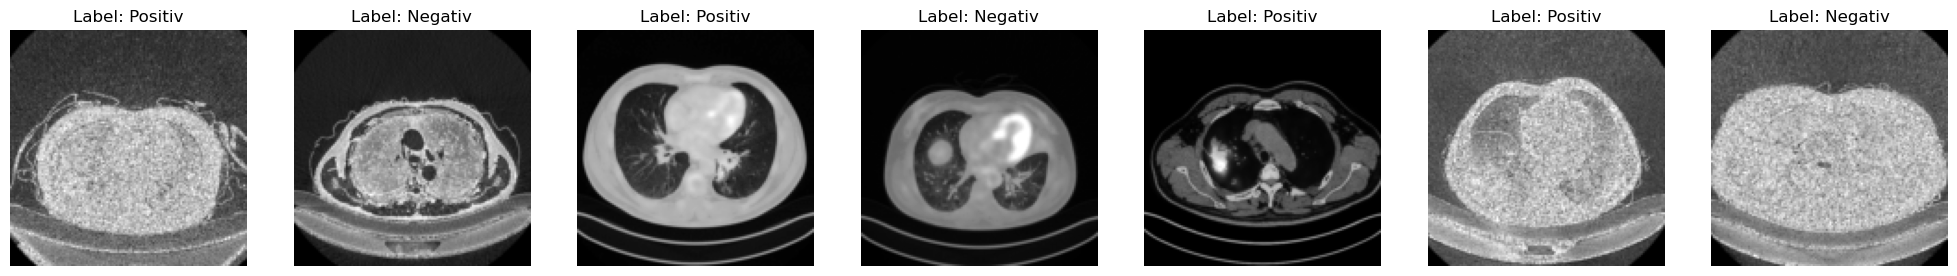

In [11]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),        # Rotate by up to ±15 degrees
    transforms.RandomResizedCrop((224, 224),      # Random crop and resize to simulate zooming
                    scale=(0.8, 1.2),  # Scale for zoom in/out
                    ratio=(0.9, 1.1)),
    transforms.RandomAffine(degrees=0, shear=10), # Apply random shear with ±10 degrees
    transform
])



dataset = DICOMPETDataset(df=smallbalanced_df, transform=transform, target_size=(image_size, image_size))
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=["nodule", "non-nodule"], transform=transform, scenario=1)
dataset.visualize_images(num_images=7)

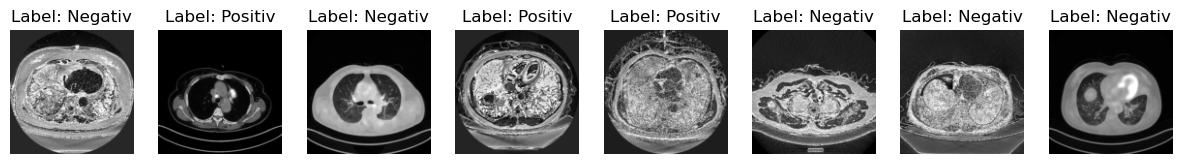

In [13]:
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# train_dataset.dataset.transform = train_transforms
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

display_data_loader_batch(train_loader, ['Negativ','Positiv'])

In [14]:

model = CapsuleNetwork(image_size=image_size)
model = model.to(device)
model

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=16384, bias=True)
      (5): Sigmoid()
    )
  )
)

In [15]:
criterion = CapsuleLoss()
optimizer = optim.Adam(model.parameters())


n_epochs = 5
losses = model.train_model(train_loader, criterion, optimizer, n_epochs, print_every=1)

Epoch: 1 	Training Loss: 18.66475582
Epoch: 1 	Training Loss: 9.66192245
Epoch: 1 	Training Loss: 9.32916927
Epoch: 1 	Training Loss: 8.91661358
Epoch: 1 	Training Loss: 8.28586292
Epoch: 1 	Training Loss: 8.69149971
Epoch: 1 	Training Loss: 7.50739288
Epoch: 1 	Training Loss: 7.42943525
Epoch: 1 	Training Loss: 8.05169010
Epoch: 1 	Training Loss: 5.42480659
Epoch: 1 	Training Loss: 5.55806684
Epoch: 1 	Training Loss: 5.23880720
Epoch: 1 	Training Loss: 4.19168139
Epoch: 1 	Training Loss: 4.37258387
Epoch: 1 	Training Loss: 4.03116846
Epoch: 1 	Training Loss: 4.81713724
Epoch: 1 	Training Loss: 5.06213617
Epoch: 1 	Training Loss: 3.74532557
Epoch: 1 	Training Loss: 4.19686604
Epoch: 1 	Training Loss: 4.39181566
Epoch: 1 	Training Loss: 3.77013850
Epoch: 1 	Training Loss: 3.20778966
Epoch: 1 	Training Loss: 3.99614310
Epoch: 1 	Training Loss: 4.42292118
Epoch: 1 	Training Loss: 3.49847269
Epoch: 1 	Training Loss: 3.31515765
Epoch: 1 	Training Loss: 3.30405474
Epoch: 1 	Training Loss: 2.

KeyboardInterrupt: 